<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Compare-dimensionalities" data-toc-modified-id="Compare-dimensionalities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare dimensionalities</a></span></li><li><span><a href="#Find-&quot;single-gene&quot;-iModulons" data-toc-modified-id="Find-&quot;single-gene&quot;-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find "single-gene" iModulons</a></span></li><li><span><a href="#Plot-Components" data-toc-modified-id="Plot-Components-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot Components</a></span></li></ul></div>

In [1]:
from pymodulon.core import IcaData
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# Directory containing ICA outputs
DATA_DIR = '../data/ica_runs'

# Load Data

In [3]:
def load_M(dim):
    return pd.read_csv(os.path.join(DATA_DIR,str(dim),'S.csv'),index_col=0)

def load_A(dim):
    return pd.read_csv(os.path.join(DATA_DIR,str(dim),'A.csv'),index_col=0)

In [4]:
dims = sorted([int(x) for x in os.listdir(DATA_DIR) if x != '.DS_Store'])
M_data = [load_M(dim) for dim in dims]
A_data = [load_A(dim) for dim in dims]

In [5]:
n_components = [m.shape[1] for m in M_data]

# Compare dimensionalities

In [6]:
final_m = M_data[-1]
thresh = 0.7

In [7]:
n_final_mods = []
for m in tqdm(M_data):
    corrs = pd.DataFrame(index=final_m.columns,columns=m.columns)
    for col1 in final_m.columns:
        for col2 in m.columns:
            corrs.loc[col1,col2] = abs(stats.pearsonr(final_m[col1],m[col2])[0])
    n_final_mods.append(len(np.where(corrs > thresh)[0]))

# Find "single-gene" iModulons
At a high enough dimensionality, some iModulons track the expression trajectory of a single iModulon

In [8]:
n_single_genes = []
for m in tqdm(M_data):
    counter = 0
    for col in m.columns:
        sorted_genes = abs(m[col]).sort_values(ascending=False)
        if sorted_genes.iloc[0] > 2 * sorted_genes.iloc[1]:
            counter += 1
    n_single_genes.append(counter)

# Plot Components

In [9]:
non_single_components = np.array(n_components) - np.array(n_single_genes)

In [10]:
DF_stats = pd.DataFrame([n_components,n_final_mods,non_single_components,n_single_genes],
                        index=['Robust Components','Final Components','Multi-gene Components',
                        'Single Gene Components'],
                        columns=dims).T
DF_stats.sort_index(inplace=True)

In [11]:
dimensionality = DF_stats[DF_stats['Final Components'] >= DF_stats['Multi-gene Components']].iloc[0].name
print('Optimal Dimensionality:',dimensionality)

Optimal Dimensionality: 80


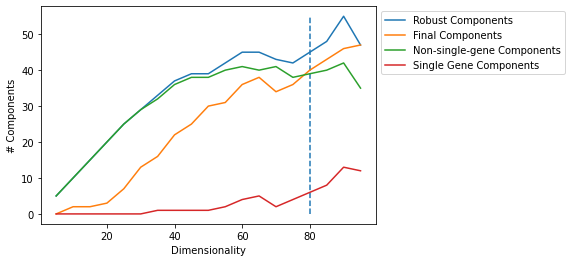

In [12]:
plt.plot(dims,n_components,label='Robust Components')
plt.plot(dims,n_final_mods,label='Final Components')
plt.plot(dims,non_single_components,label='Non-single-gene Components')
plt.plot(dims,n_single_genes,label='Single Gene Components')

plt.vlines(dimensionality,0,max(n_components),linestyle='dashed')

plt.xlabel('Dimensionality')
plt.ylabel('# Components')
plt.legend(bbox_to_anchor=(1,1))